For tabular data, generally bagging and boosting models performs better in terms of accuracy and computational resources. For tabular data, we also need to perform feature engineering before using models and it lacks baseline models. However, in industry there are stakeholders that are interested in Deep learning architectures for tabular data.

## FTTransformer(Feature Tokenizer + Transformer)
In [paper](https://openreview.net/forum?id=i_Q1yrOegLY) 'Revisiting Deep Learning Models for Tabular Data', authors introduces implementation of original Transformer architecture for tabular data. We will go through its architechture and its implementation for this Dataset. You can find its detail discussion on https://www.youtube.com/watch?v=59uGzJaVzYc&t=1540s by weights & biases.

Its architecture is adapted from original transformer paper([Vasvani et al. 2017](https://arxiv.org/abs/1706.03762)). As shown in below figure, x is input features(categoricals+numericals) and through feature tokensizer it gets transformed to embeddings and layers of transformers is applied on it

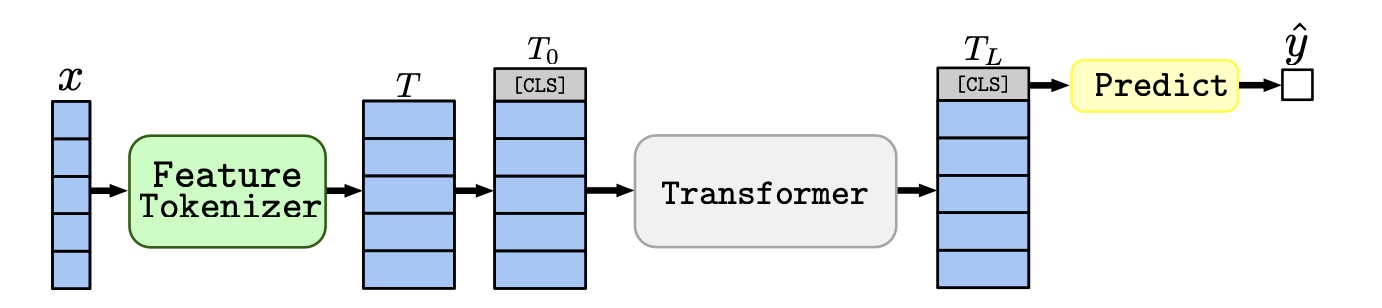
Below figure is from [paper](https://openreview.net/forum?id=i_Q1yrOegLY). In part (a) of figure, feature tokensizer is represented where $x^(num)$ represents all numerical features and $x^(cat)$ represents categorical features. 
* In below figure there are 3 numerical features and 2 categorical features.
* Each categorical and numerical feature is transformed into embedding by 
$T_j = b_j + f_j (x_j ) \in R^d$ where $f_j : X_j → R_d$ and X represents features.
* Transformed embedding are then concatenated or stacked and Classification token or output token([CLS] shown in above figure) is appended to transformer layers
* Predicted output is represented as $y^ˆ = Linear(ReLU(LayerNorm(T
[CLS]L))).$
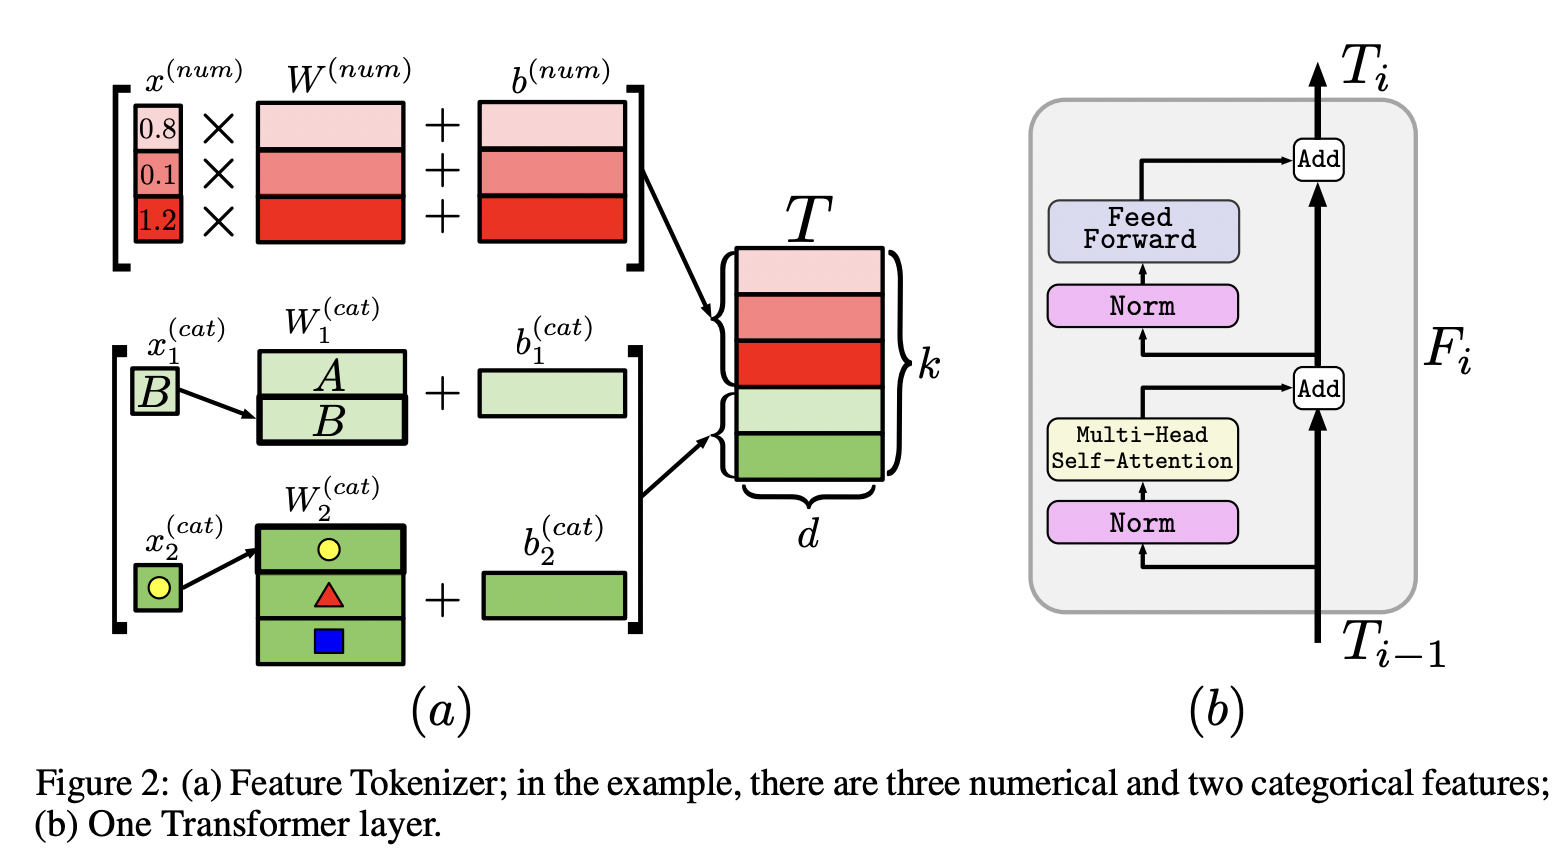

#### Now we will dive into its code. 
Install rtdl library: Find its detailed code https://github.com/yandex-research/rtdl. Do select the GPU as Accelerator.

In [1]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero
import pandas as pd
import numpy as np
from torch.autograd import Variable

In [10]:
pwd

'/home/mattyshen/interpretableDistillation/simulations/WiDS_Datathon_2022'

## Load dataset

In [11]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv').fillna(0)

In [5]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

In [12]:
df_train

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,5375,3.948791e+09,24563.46,6.73,0.00035,9.871977e+08,0.43,3303184.55,3154159.0,4439.0,...,0.0000,158603315,0.05,0.0,0,0.0,2.7480,93.45,0.22,4
5376,5376,9.279017e+10,21572.94,6.96,0.00120,3.093006e+09,0.30,2649164.57,2934417.0,19106.0,...,0.0003,36089167,0.01,6.0,4,4.0,23.6890,76.05,-0.90,8
5377,5377,2.700359e+10,23061.73,6.36,0.00065,3.857656e+09,0.35,1825306.07,2395841.0,71514.0,...,0.0057,1786891,0.53,44.0,0,28.0,4.3710,80.30,-0.70,21
5378,5378,4.351107e+10,5739.04,7.80,0.00065,1.318517e+09,0.29,144103.12,715173.0,13977.0,...,0.0001,194000000000,0.29,3.0,2,2.0,24.6594,7.95,0.47,13


### Split train and validation data

In [7]:
dataset = df_train.fillna(0)
task_type = 'regression'
catfeatures = ['Year_Factor', 'State_Factor', 'building_class', 'facility_type']
numfeatures = dataset.drop(['id','site_eui']+catfeatures, axis=1).columns.tolist()
X_all = dataset[numfeatures].astype('double')
y_all = dataset['site_eui'].astype('double' if task_type == 'regression' else 'int64')
if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}
X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    dataset.drop(['id','site_eui'], axis=1), dataset['site_eui'], train_size=0.8
)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)
n_features = dataset.drop(['site_eui'], axis=1).shape[1]

#Calculate cardinalities as number of unique category values for each categorical features
cardinalities = [df_train.iloc[:,0].nunique(), df_train.iloc[:,1].nunique(), df_train.iloc[:,2].nunique(), df_train.iloc[:,3].nunique()]

KeyError: "['site_eui', 'Year_Factor', 'State_Factor', 'building_class', 'facility_type'] not found in axis"

## Preprocess data

In [32]:
# not the best way to preprocess features, but for the demonstration purpose
def PreprocessNumFeatures(X, y, numfeatures):
    "normalize features"
    preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'][numfeatures])
    X = {
        k: torch.tensor(preprocess.fit_transform(v[numfeatures]))
        for k, v in X.items()
    }
    y = {k: torch.tensor(v.tolist()) for k, v in y.items()}
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
    y = {k: v.float() for k, v in y.items()}  
    return X, y, y_mean, y_std, preprocess
def PreprocessCatFeatures(X, catfeatures):
    "Convert categorical(string format) to numerical category"
    preprocess = sklearn.preprocessing.OrdinalEncoder().fit(X['train'][catfeatures])
    X = {
        k: torch.tensor(preprocess.fit_transform(v[catfeatures])).to(torch.int64)
        for k, v in X.items()
    }
    return X, preprocess
# def categoricalEncoded(X):
#     "encoding for categorical features"
#     d_token = 3
#     cat_tokenizer =  rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform')
#     return cat_tokenizer(torch.tensor(X).to(torch.int64))
X_num, y,y_mean, y_std, scale = PreprocessNumFeatures(X, y, numfeatures)
X_cat, ordinal = PreprocessCatFeatures(X, catfeatures)


### Prepare test set

In [9]:

def preprocess_test(df, scale, ordinal, numfeatures, catfeatures):
    X_cat = torch.from_numpy(ordinal.fit_transform(df[catfeatures]))
    X_num = torch.from_numpy(scale.fit_transform(df[numfeatures]))
    
    return X_cat,X_num
        
test_cat, test_num = preprocess_test(df_test.drop(['id'], axis=1),scale, ordinal, numfeatures, catfeatures)

## Define model

In [17]:
model = rtdl.FTTransformer.make_default(
    n_num_features=X_num['train'].shape[1],
    cat_cardinalities=cardinalities,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=1,
)

In [18]:
model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [19]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num.float(), x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )

In [20]:

@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(torch.cat((X_num[part],X_cat[part]), 1) ,1024):
#         print(apply_model(batch))
        prediction.append(apply_model(batch[:,:58], batch[:, -4:].to(torch.int64)))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score



batch_size = 64
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 64.2699


## Train model

In [21]:
n_epochs = 4 # can increase the epoch size 
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_num_batch = X_num['train'][batch_idx]
        x_cat_batch = X_cat['train'][batch_idx].to(torch.int64)
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_num_batch, x_cat_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val')
    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

(epoch) 1 (batch) 0 (loss) 0.9135
(epoch) 1 (batch) 151 (loss) 1.5868
(epoch) 1 (batch) 302 (loss) 0.4819
(epoch) 1 (batch) 453 (loss) 0.4715
(epoch) 1 (batch) 604 (loss) 0.3539
(epoch) 1 (batch) 755 (loss) 0.6142
Epoch 001 | Validation score: 55.0748 | Test score: 51.3424 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.3300
(epoch) 2 (batch) 151 (loss) 1.3359
(epoch) 2 (batch) 302 (loss) 0.5440
(epoch) 2 (batch) 453 (loss) 0.4425
(epoch) 2 (batch) 604 (loss) 0.3069
(epoch) 2 (batch) 755 (loss) 0.7282
Epoch 002 | Validation score: 56.3601 | Test score: 50.8375
(epoch) 3 (batch) 0 (loss) 0.3188
(epoch) 3 (batch) 151 (loss) 1.2884
(epoch) 3 (batch) 302 (loss) 0.5208
(epoch) 3 (batch) 453 (loss) 0.4554
(epoch) 3 (batch) 604 (loss) 0.3221
(epoch) 3 (batch) 755 (loss) 0.5976
Epoch 003 | Validation score: 56.3200 | Test score: 50.5017
(epoch) 4 (batch) 0 (loss) 0.3309
(epoch) 4 (batch) 151 (loss) 1.2524
(epoch) 4 (batch) 302 (loss) 0.5025
(epoch) 4 (batch) 453 (loss) 0.4570
(epoch) 4 

In [22]:
torch.save(model, 'model_params.pt')

### Load model using GPU to predict

In [12]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [18]:
model = torch.load('../input/model-params/model_params.pt')

In [19]:
if USE_GPU and torch.cuda.is_available():
    test_num = test_num.float().cuda()
    test_cat = test_cat.to(torch.int64).cuda()
    dtype1 = torch.cuda.FloatTensor
    dtype2 = torch.cuda.IntTensor
    model.cuda()
else:
    test_num = test_num.float()
    test_cat = test_cat.to(torch.int64)
    dtype1 = torch.FloatTensor
    dtype2 = torch.cuda.IntTensor

test_num = Variable(test_num).type(dtype1)
test_cat = Variable(test_cat).type(dtype2)


In [21]:
model.eval()
with torch.no_grad():
    predict = model(test_num, test_cat)

In [38]:
Submission = pd.DataFrame()
Submission['id'] = df_test['id']
Submission['site_eui'] = (predict.cpu().detach().numpy() * y_std) + y_mean
Submission.to_csv('submission.csv', index=False)

### Reference
* https://github.com/yandex-research/rtdl/blob/main/examples/rtdl.ipynb
* https://arxiv.org/abs/2106.11959
* https://yandex-research.github.io/rtdl/stable/index.html